# 구글 DeepLab 모델로 인물 사진, 고양이 사진 배경 Blur 처리 하기

## Step 0. 모듈 import 하기

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

## Step 1. 사진 준비 하기
* 첫번째 사진은 부산여행 갔을 때 친구와 찍은 인물사진 입니다.
* 두번째 사진은 한국민속촌에서 찍은 고양이 사진입니다.

In [2]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image3.JPG'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(3456, 5184, 3)


In [3]:
import os
img_path_cat = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image5.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_cat = cv2.imread(img_path_cat) 
print (img_cat.shape)

(3024, 3024, 3)


## Step 2. 시맨틱 세그멘테이션 다뤄보기 : DeepLab 모델을 준비
* 구글에서 제공하는 모델 구조를 그대로 가지고 와 DeepLabModel 클래스를 만들었다.

In [4]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

## Step 2-1. 사전에 학습된 가중치(pretrained weight)를 불러 오기

In [5]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/aiffel-dj17/aiffel/human_segmentation/models
model loaded successfully!


## Step 2-2. 준비한 이미지를 네트워크에 입력
* 세그멘테이션 맥스가 15가 나온 것을 알 수 있다. 이 네트워크는 최대 15가지 종류의 이미지를 세그멘테이션 할 수 있는 것 같다.

In [6]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(3456, 5184, 3) (342, 513, 3) 15


In [7]:
img_resized_cat, seg_map_cat = MODEL.run(img_cat)
print (img_orig.shape, img_resized.shape, seg_map.max())

(3456, 5184, 3) (342, 513, 3) 15


## Step 2-3. 구글에서 제공하는 라벨 확인하기
* 고양이는 8, 사람은 15이다.

In [8]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

* 사람은 15이기 때문에 seg_map 변수에 15,15를 넣어주었다.

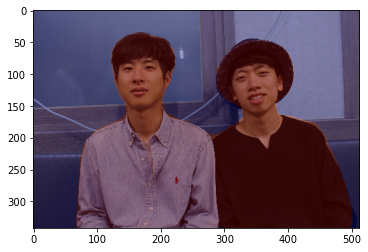

In [9]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

* 고양이는 8이기 때문에 seg_map 변수에 8,8를 넣어주었다.

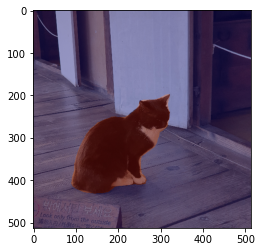

In [10]:
img_show_cat = img_resized_cat.copy()
seg_map_cat = np.where(seg_map_cat == 8, 8, 0) # 예측 중 고양이만 추출
img_mask_cat = seg_map_cat * (255/seg_map_cat.max()) # 255 normalization
img_mask_cat = img_mask_cat.astype(np.uint8)
color_mask_cat = cv2.applyColorMap(img_mask_cat, cv2.COLORMAP_JET)
img_show_cat = cv2.addWeighted(img_show_cat, 0.6, color_mask_cat, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show_cat, cv2.COLOR_BGR2RGB))
plt.show()

## Step 3. 시멘틱 세그멘테이션 결과를 원래 크기로 복원하기

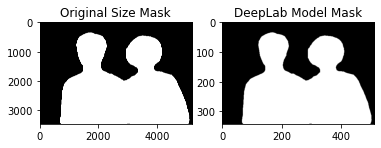

In [11]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

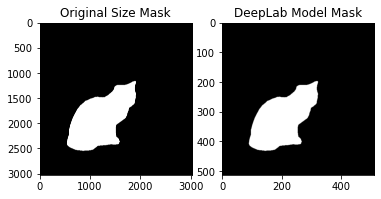

In [12]:
img_mask_up_cat = cv2.resize(img_mask_cat, img_cat.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up_cat = cv2.threshold(img_mask_up_cat, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up_cat, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask_cat, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

## Step 4. 인물사진 배경 흐리게 하기

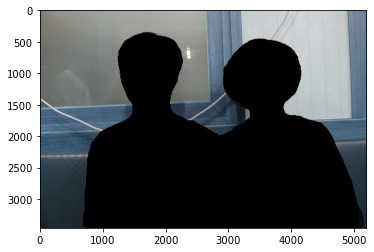

In [13]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

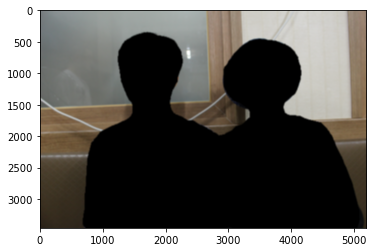

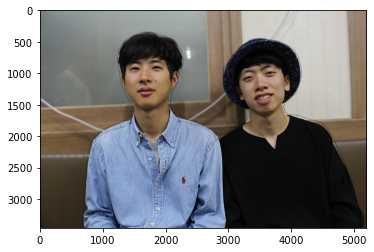

In [38]:
img_bg_blur2 = cv2.blur(img_bg, (30,30))
plt.imshow(cv2.cvtColor(img_bg_blur2, cv2.COLOR_BGR2RGB))
plt.show()
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur2)
img_Blur = img_concat
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## Step 5. 문제점 찾기
* 요즘 사진기술이 발달되어 자동적으로 배경이 약간 blur 처리된 사진들이 많다.
* 그래서 blur 처리된 것을 확실하게 보려고 blur함수에 값을 30,30 이렇게 높이다 보면 이질적인 검은색 선이 생긴다.


![Screenshot from 2021-02-23 22-12-59](https://user-images.githubusercontent.com/60597598/108848607-8825a200-7624-11eb-8964-c900a598d6c6.png)

## Step 6. 문제점 해결
* 그래서 구글링 해보니 opencv모듈에서 제공하는 blur 기법들이 여러가지 라는 것을 알게되었고 다른 blur 기법들을 적용해 보았다.   
참조 : https://webnautes.tistory.com/1255
---
* 평균 블러링(Averaging Blurring) : 커널을 만들어서 컨볼루션하는 번거로움을 줄이기 위해 OpenCV에서는 블러링하는 함수를 제공한다. 앞에서 살펴본 5 x 5  범위내 이웃 픽셀의 평균을 결과 이미지의 픽셀값으로하는 평균 블러링을 하는 blur함수가 있다.   
---
* 가우시안 블러링(Gaussian Blurring) : 모든 픽셀에 똑같은 가중치를 부여했던 평균 블러링과 달리 가우시안 블러링은 중심에 있는 픽셀에 높은 가중치를 부여한다.   
---
* 미디안 블러링(Median Blurring) : 관심화소 주변으로 지정한 커널 크기( 5 x 5) 내의 픽셀을 크기순으로 정렬한 후 중간값을 뽑아서 픽셀값으로 사용한다.   
---
* Bilateral Filtering : 에지를 보존하면서 노이즈를 감소시킬수 있는 방법이다.



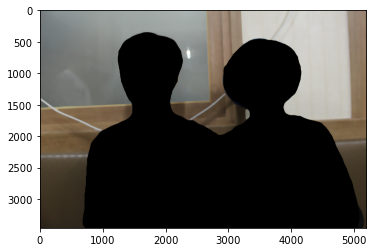

In [14]:
img_bg_blur = cv2.medianBlur(img_bg, 45)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

* medianBlur 함수에 45라는 큰 값을 넣어줘도 이질감이 거의 없다.

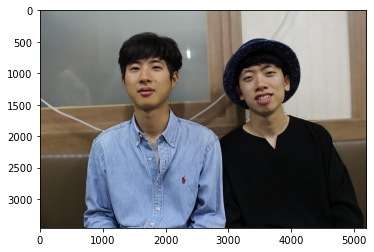

In [15]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
img_medianBlur = img_concat
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

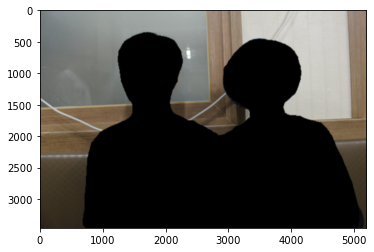

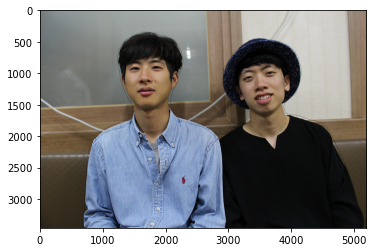

In [18]:
img_bg_blur3 = cv2.GaussianBlur(img_bg, (39,39), 0)
plt.imshow(cv2.cvtColor(img_bg_blur3, cv2.COLOR_BGR2RGB))
plt.show()
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur3)
img_GaussianBlur = img_concat
plt.imshow(cv2.cvtColor(img_GaussianBlur, cv2.COLOR_BGR2RGB))
plt.show()

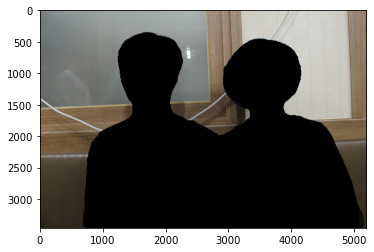

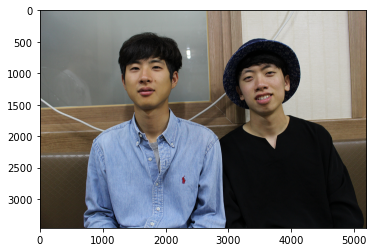

In [20]:
img_bg_blur4 = cv2.bilateralFilter(img_bg, 9, 75, 75)
plt.imshow(cv2.cvtColor(img_bg_blur4, cv2.COLOR_BGR2RGB))
plt.show()
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur4)
img_bilateralFilter = img_concat
plt.imshow(cv2.cvtColor(img_bilateralFilter, cv2.COLOR_BGR2RGB))
plt.show()

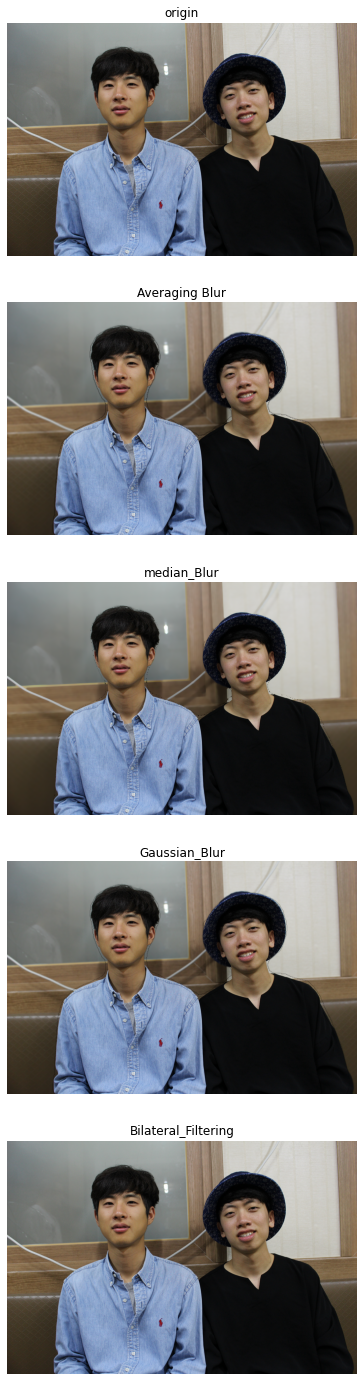

In [25]:
fig = plt.figure(figsize=(30,30))
ax1 = fig.add_subplot(6, 1, 1)
ax1.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
ax1.set_title('origin')
ax1.axis("off")

ax2 = fig.add_subplot(6, 1, 2)
ax2.imshow(cv2.cvtColor(img_Blur, cv2.COLOR_BGR2RGB))
ax2.set_title('Averaging Blur')
ax2.axis("off")

ax3 = fig.add_subplot(6, 1, 3)
ax3.imshow(cv2.cvtColor(img_medianBlur, cv2.COLOR_BGR2RGB))
ax3.set_title('median_Blur')
ax3.axis("off")

ax4 = fig.add_subplot(6, 1, 4)
ax4.imshow(cv2.cvtColor(img_GaussianBlur, cv2.COLOR_BGR2RGB))
ax4.set_title('Gaussian_Blur')
ax4.axis("off")

ax5 = fig.add_subplot(6, 1, 5)
ax5.imshow(cv2.cvtColor(img_bilateralFilter, cv2.COLOR_BGR2RGB))
ax5.set_title('Bilateral_Filtering')
ax5.axis("off")

plt.show()

## Step 6-1. 여러 blur 비교하기
* 이중에 median_blur 가 가장 이질감이 없는것을 확인할 수 있다. bilaterial_filtering 은 아무 효과가 없는듯 했다.

## Step 7. 고양이 사진 에도 적용하기

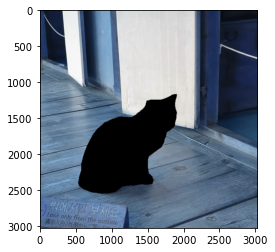

In [34]:
img_mask_color_cat = cv2.cvtColor(img_mask_up_cat, cv2.COLOR_GRAY2BGR)
img_bg_mask_cat = cv2.bitwise_not(img_mask_color_cat)
img_bg_cat = cv2.bitwise_and(img_cat, img_bg_mask_cat)
plt.imshow(img_bg_cat)
plt.show()

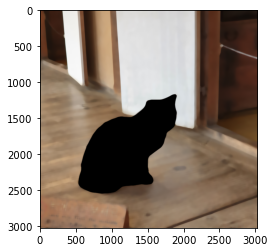

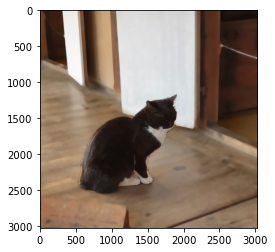

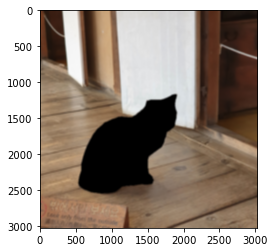

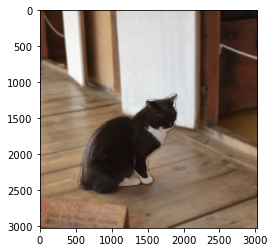

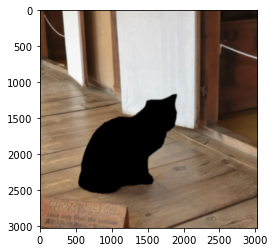

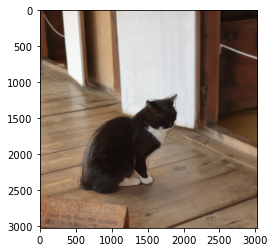

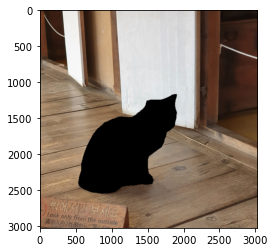

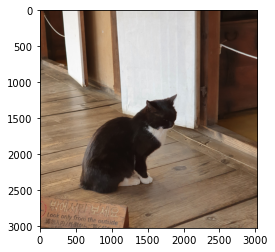

In [36]:
img_bg_blur_cat = cv2.medianBlur(img_bg_cat, 45)
plt.imshow(cv2.cvtColor(img_bg_blur_cat, cv2.COLOR_BGR2RGB))
plt.show()
img_concat = np.where(img_mask_color_cat==255, img_cat, img_bg_blur_cat)
img_medianBlur = img_concat
plt.imshow(cv2.cvtColor(img_medianBlur, cv2.COLOR_BGR2RGB))
plt.show()
img_bg_blur2 = cv2.blur(img_bg_cat, (30,30))
plt.imshow(cv2.cvtColor(img_bg_blur2, cv2.COLOR_BGR2RGB))
plt.show()
img_concat = np.where(img_mask_color_cat==255, img_cat, img_bg_blur2)
img_Blur = img_concat
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()
img_bg_blur3 = cv2.GaussianBlur(img_bg_cat, (39,39), 0)
plt.imshow(cv2.cvtColor(img_bg_blur3, cv2.COLOR_BGR2RGB))
plt.show()
img_concat = np.where(img_mask_color_cat==255, img_cat, img_bg_blur3)
img_GaussianBlur = img_concat
plt.imshow(cv2.cvtColor(img_GaussianBlur, cv2.COLOR_BGR2RGB))
plt.show()
img_bg_blur4 = cv2.bilateralFilter(img_bg_cat, 9, 75, 75)
plt.imshow(cv2.cvtColor(img_bg_blur4, cv2.COLOR_BGR2RGB))
plt.show()
img_concat = np.where(img_mask_color_cat==255, img_cat, img_bg_blur4)
img_bilateralFilter = img_concat
plt.imshow(cv2.cvtColor(img_bilateralFilter, cv2.COLOR_BGR2RGB))
plt.show()

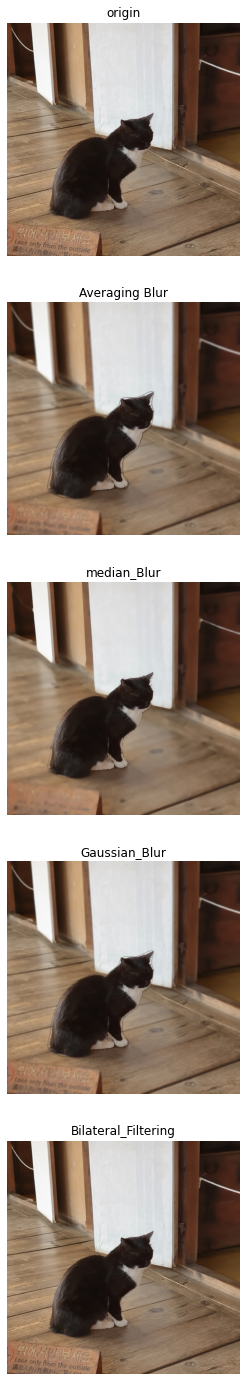

In [37]:
fig = plt.figure(figsize=(30,30))
ax1 = fig.add_subplot(6, 1, 1)
ax1.imshow(cv2.cvtColor(img_cat, cv2.COLOR_BGR2RGB))
ax1.set_title('origin')
ax1.axis("off")

ax2 = fig.add_subplot(6, 1, 2)
ax2.imshow(cv2.cvtColor(img_Blur, cv2.COLOR_BGR2RGB))
ax2.set_title('Averaging Blur')
ax2.axis("off")

ax3 = fig.add_subplot(6, 1, 3)
ax3.imshow(cv2.cvtColor(img_medianBlur, cv2.COLOR_BGR2RGB))
ax3.set_title('median_Blur')
ax3.axis("off")

ax4 = fig.add_subplot(6, 1, 4)
ax4.imshow(cv2.cvtColor(img_GaussianBlur, cv2.COLOR_BGR2RGB))
ax4.set_title('Gaussian_Blur')
ax4.axis("off")

ax5 = fig.add_subplot(6, 1, 5)
ax5.imshow(cv2.cvtColor(img_bilateralFilter, cv2.COLOR_BGR2RGB))
ax5.set_title('Bilateral_Filtering')
ax5.axis("off")

plt.show()

* 고양이 사진에서도 median_blur 효과가 좋았다. bilaterial_filtering 은 아무 효과가 없는듯 했다.

# 마치며...   
* 여러 사진들에 여러가지 blur 함수를 적용하여 문제를 해결했다. 만약 3d deepth carmera를 사용한다면 입력 값이 3차원이 아니고 4차원 일 것 같다. 추가된 차원이 거리에 대한 값이다. 그러면 이미지 세그멘테이션을 하고 각 세그멘테이션 한 부분마다 거리값이 있을 것이다. 그러면 이 거리값을 threshhold 값으로 if문을 써서 멀리 있는 세그멘테이션은 blur 처리를 하면 될 것 같다.